In [1]:
#import sys
#sys.path.append("/home/klar/Promotion/projects/nonlocal-assembly")

# Setting

Let $\Omega = B_1$ and $\Omega_I = B_{1+\delta}\setminus B_1$, and $\overline{\Omega} = \Omega \cup \Omega_I$.
We are given $n$ Ansatzfunctions
$$
\Phi = (\phi_1, \phi_2)  \in \mathcal{L}(\overline{\Omega})^2.
$$
in a discretization of a 2-D Grid.

### Configuration

In [2]:
from duffyconf import *
import meshio
import matplotlib.pyplot as plt
import numpy as np

In [3]:
mesh = meshio.read(DATA_PATH + mesh_name)

### Ansatz function

In [4]:
class V:
    def __init__(self, mesh):
        self.points = mesh.points[:,:2]
        self.N = self.points.shape[0]
        self.triangles = mesh.cells[1][1]
        
    def phi1(self, p):
        return 1 - p[0] - p[1]
    
    def phi2(self, p):
        return p[0]
    
    def phi3(self, p):
        return p[1]
    
    def __getitem__(self, k):
        phi = [self.phi1, self.phi2, self.phi3]
        #n, k = index
        return phi[k]
    
    def plot(self):
        plt.scatter(self.points[:,0], self.points[:,1], s=.1)
        plt.scatter(0,0)
        plt.show()
    
class T:
    def __init__(self, mesh):
        self.triangles = mesh.cells[1][1]
        self.points = mesh.points[:,:2]
        self.N = self.triangles.shape[0]
        self.tris = []
        for k in range(self.N):
            Vdx = self.triangles[k]
            a,b,c = np.array(self.points[Vdx])
            self.tris.append(Triangle(a,b,c))
    def __getitem__(self, k):
        return self.tris[k]
    
    def join(self, aTdx, bTdx):
        """ This method reoders the vertices of two triangles such that 
        coinciding nodes come first. If more than one vertex coincides
        the coinciding vertices are again ordered by index size.
        """
        
        # Read Vertex indices
        AVdx = self.triangles[aTdx]
        BVdx = self.triangles[bTdx]
        # Find equal indices
        isEqualVertex = (np.subtract.outer(AVdx, BVdx) == 0)
        nEqual = np.sum(isEqualVertex)
        # Reorder indices 
        # (Equal vertices first, 
        # and if there is more than one the vertices are again ordered by index size)
        AVdx = AVdx[np.argsort(-AVdx*np.sum(isEqualVertex, axis=1))]
        BVdx = BVdx[np.argsort(-BVdx*np.sum(isEqualVertex, axis=0))]
        
        #print("Found ", nEqual, "equal vertices. \n", AVdx, "\n", BVdx)        
        
        # Construct Triangle, i.e. the affine map from reorderd indices.
        a,b,c = self.points[AVdx]
        A = Triangle(a,b,c)
        a,b,c = self.points[BVdx]
        B = Triangle(a,b,c)
        
        return A, B, nEqual
    
class Triangle:
    def __init__(self, a,b,c):
        self.M = np.array([b-a, c-a]).T
        self.det = np.abs(np.linalg.det(self.M))
        self.E = np.array([a,b,c])
        self.a = a
        self.b = b
        self.c = c
        
    def __call__(self, x):
        return self.M@x + self.a
def C(z):
    return np.outer(z,z)

def kernel(z):
    d = np.linalg.norm(z)
    return 1./d**3
    #else:
    #    print("Zero Division!")
    #    return 1.
        
def kernel1D(x,y):
    z = x-y
    d = np.linalg.norm(z)
    if d>1e-6:
        return 1./d
    else:
        print("Zero Division!")
        return 1.

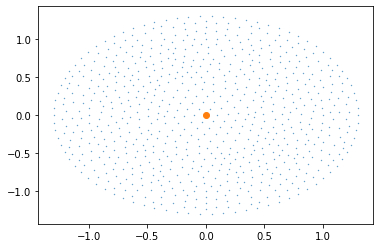

In [5]:
Ansatz = V(mesh)
Triangles = T(mesh)

Ansatz.plot()

### Scalar Kernel Integral on Disk of Radius of $\delta$

We set $\delta = 0.3$.

As warm up we simply integrate the circle weighted with the kernel for $x = (0,0)$. The analytic solution is obtained by.
$$
\sum_{A \in \mathcal{T}} \int_A \frac{1}{\|x-y\|} dy
$$
Where the analytic solution is given by
$$
\int_{B_{1+\delta}} \frac{1}{\|z\|} dz = 
\int_0^{1+\delta} \int_0^{2\pi} \frac{r}{r} d\phi dr = (1+\delta) 2 \pi. 
$$

as the determinant of the Jacobian is $r$ for $\phi: (r, \phi) \mapsto r (sin(\phi), cos(\phi))$ .

In [6]:
x = np.zeros((2,))
integral = 0.

for k in range(Triangles.N):
    tri = Triangles[k]
    n = dy.shape[0]
    s = 0
    for i in range(n):
        y = tri.M@Py[i] + tri.a
        s += kernel1D(x, y)*tri.det*dy[i]
    integral += s
print("Integral\t", integral)
print("True value\t", 2*np.pi*(1+delta))

Integral	 8.151759178074103
True value	 8.168140899333462


### Peridynamics Kernel on Disk of Radius of $\delta$

We set $\delta = 0.3$.

Now we integrate the simplest version of the peridynamics-kernel for $x = (0,0)$. The analytic solution is obtained by.

$$
\sum_{A \in \mathcal{T}} \int_A \frac{(x-y) \otimes (x-y)}{\|x-y\|^3}  dy = \textbf{I}
$$
Where the analytic solution is given by
$$
\textbf{I}_{2,2} = \textbf{I}_{1,1} = \int_{B_{1+\delta}} \frac{z_1^2}{\|z\|} dz = 
\int_0^{1+\delta} \int_0^{2\pi} \frac{sin^2(\phi) r^2}{r^3}r d\phi dr = (1+\delta) \int_0^{2\pi}sin^2(\phi) d\phi. 
$$
$$
= (1+\delta) \left[ \frac{1}{2}(\phi - sin(\phi)cos(\phi) \right]_0^{2\pi} = (1+\delta)\pi. 
$$
and
$$
\textbf{I}_{2,1} = \textbf{I}_{1,2} = \int_{B_{1+\delta}} \frac{z_1 z_2}{\|z\|} dz = 
\int_0^{1+\delta} \int_0^{2\pi} \frac{sin(\phi)cos(\phi) r^2}{r^3}r d\phi dr = (1+\delta) \int_0^{2\pi}sin(\phi)cos(\phi) d\phi = 0. 
$$

In [7]:
x = np.zeros((2,))
integral = 0.
Det = np.zeros(Triangles.N)
for k in range(Triangles.N):
    tri = Triangles[k]
    s = 0
    n = dy.shape[0]
    for i in range(n):
        y = tri.M@Py[i] + tri.a
        s += C(x-y)*kernel(x-y)*tri.det*dy[i]
    integral += s
print("Integral\n", integral)
print("\nTrue value\n", np.eye(2)*np.pi*(1+delta))


Integral
 [[4.07635907e+00 7.59845636e-04]
 [7.59845636e-04 4.07540011e+00]]

True value
 [[4.08407045 0.        ]
 [0.         4.08407045]]


# 4D Tensor Gauss Quadrature Rule

As preparation we need a tensor gauss quadrature rule. The number of quadrature points is given in the table.

Degree | #Quad Points |
-|-|
2      | 16    |
4      | 256   |
6      | 1296  |
8      | 4096  |

Number of quadrature points  1296 



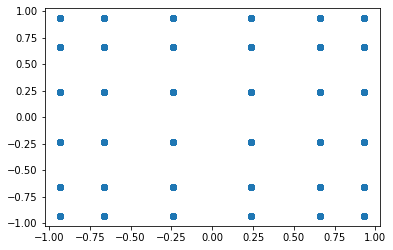

In [8]:
# Tensor Gauss Quadrature
class tensorgauss:
    def __init__(self, deg, dim=4):
        self.deg = deg
        self.dim = 4
        p, w = np.polynomial.legendre.leggauss(deg)
        #print("Length", len(p), "\np", p, "w", w)
        self.N = deg**dim
        self.weights = np.zeros(deg**dim)
        self.points = np.zeros((dim, deg**dim))
        l = 0
        k1 = 0
        k2 = 0
        k3 = 0
        for l in range(deg**4):
            k0 = l % deg
            k1 += (not k0) and (bool(l))
            k1 %= deg
            k2 += (not (k1 or k0)) and (bool(l))
            k2 %= deg
            k3 += (not (k2 or k1 or k0)) and (bool(l))
            self.weights[l] = w[k0]*w[k1]*w[k2]*w[k3]
            self.points[:,l] = [p[k0], p[k1], p[k2], p[k3]]
    #print(k0, k1, k2, k3, "\tw=", "{:03.2f}".format(weights[l]), "\t\tp = ", points[l,:])
q = tensorgauss(6)
print("Number of quadrature points ", q.N, "\n")
plt.scatter(q.points[0], q.points[1])
plt.show()

# Auxilliary Transform Functions

The integration function needed iterates over the integral transformations required to cancle out the singularity in the kernel.

### Scale

Maps the box $[-1,1]^2$ to $[0,1]^2$. The determinant is $\frac{1}{16}$.

### Mirror

Maps a triangle $\left\lbrace z | z_2 \in [0,1], z_1 \ in [0,z_2] \right\rbrace$ to the standart simplex  $\left\lbrace z | z_1 \in [0,1], z_2 \ in [0,1-z_1] \right\rbrace$.
$$
    x \mapsto \begin{pmatrix} 1&-1&0&0  \\ 0&1&0&0  \\  0&0&0&1  \\  0&0&1&-1\end{pmatrix}x
$$

In [9]:
def scale(alpha):
    return alpha*.5 + .5

scaledet = .5**4

def mirror(alpha):
    A = np.array([[1.,-1.,0,0],[0.,1.,0,0], [0,0,0.,1.],[0,0,1.,-1.]])
    #print(A)
    return A@alpha
mirrordet = 1.

# Integration Routine for close Neighbors

The integration expects two ordered triangles (see below) a quadrature rule and list of transformation functions, and approximates the integral

$$
    \int_A \int_B \frac{(x-y) \otimes (x-y)}{\|x-y\|^3}  dy dx = \textbf{I}.
$$

In [10]:
def integrate(A, B, q, T):
    s = 0
    for Tk in T:
        for k, alpha in enumerate(q.points.T):
            alpha = scale(alpha)
            alpha, Tdet = Tk(alpha)
            alpha = mirror(alpha)
            x = A(alpha[:2])
            y = B(alpha[2:])
            
            s+=C(x-y)*kernel(x-y)*scaledet*q.weights[k]*Tdet*A.det*B.det
    return s

# Integral $A \cap B = \emptyset$

In this (most frequent) case the Triangles have positve distance and we can omit the quadrature given above to evaluate the double integral.

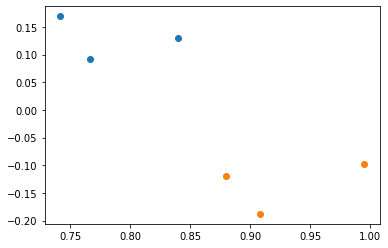

In [11]:
A = Triangles[0]
plt.scatter(A.E[:,0], A.E[:,1])

B = Triangles[4]
plt.scatter(B.E[:,0], B.E[:,1])
plt.show()   

In [12]:
nx = dx.shape[0]
ny = dy.shape[0]

integral = 0
for k in range(nx):
    x = A.M@Py[i] + A.a
    for i in range(ny):
        y = B.M@Py[i] + B.a
        integral += C(x-y)*kernel(x-y)*B.det*A.det*dy[i]*dx[k]
print("Integral\n", integral)

Integral
 [[ 7.36409677e-06 -1.67302684e-05]
 [-1.67302684e-05  4.05754846e-05]]


# Transform Functions: $A \cap B = \emptyset$

The following 2 transformations map the 4 dimensional cube into two pyramids, and are applied to the $A \cap B = \emptyset$ case. It is expected that the shared vertex is put into first position.

We also provide a *canceled* version, which incorporates the cancelation which is obtain from the determinant and **the integration kernel**. Hence, it depends on the kernel, which is the peridynamics kernel here.

In [13]:
def T1commonVertex(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta2
    
    return np.array([xi, xi*eta1, xi*eta2, xi*eta2*eta3]), det

def T2commonVertex(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta2
    return np.array([xi*eta2, xi*eta2*eta3, xi, xi*eta1]), det

TcommonVertex = [T1commonVertex, T2commonVertex]

def T1commonVertex_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    # It dependes on the kernel how many xis we lose here!
    det = xi**2*eta2 
    return np.array([1., eta1, eta2, eta2*eta3]), det

def T2commonVertex_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    # It dependes on the kernel how many xis we lose here!
    det = xi**2*eta2
    return np.array([eta2, eta2*eta3, 1., eta1]), det

TcommonVertex_canceled = [T1commonVertex_canceled, T2commonVertex_canceled]

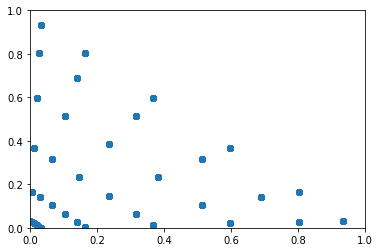

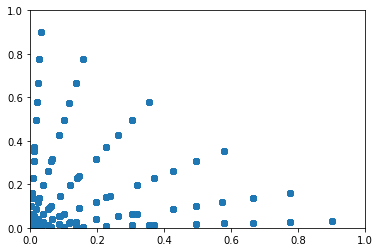

In [14]:
Beta = mirror(TcommonVertex[0](scale(q.points))[0]).T
plt.scatter(Beta[:,0], Beta[:,1])
#plt.scatter(q.points[:,0], q.points[:,1])
plt.xlim((0,1))
plt.ylim((0,1))
plt.show()

plt.scatter(Beta[:,2], Beta[:,3])
#plt.scatter(q.points[:,0], q.points[:,1])
plt.xlim((0,1))
plt.ylim((0,1))
plt.show()

# Integral where $A \cap B = \{v_0\}$

In this case the Triangles share one point. The given qudrature rule still allows to integrate the triangles without zero division, however there is a singularity *at the tip of the triangles*.
$$
    \int_A \int_B \frac{(x-y) \otimes (x-y)}{\|x-y\|^3}  dy dx = \textbf{I}
$$
We will use the naive integral as test case for the transformed version, as in the special case the quadrature rules do not lead to a zero division.

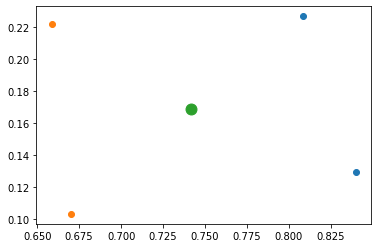

In [15]:
A, B, nEqual = Triangles.join(2, 224)

plt.scatter(A.E[:,0], A.E[:,1])
plt.scatter(B.E[:,0], B.E[:,1])
plt.scatter(B.E[:nEqual,0], B.E[:nEqual,1], s = 120)
plt.show()

### Plot of Quadrature Rule

To get a feeling only we plot the quadrature points and connect points which enter the quadrature rule together by a line.

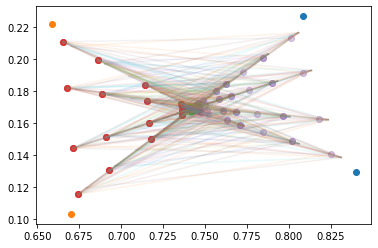

In [16]:
q = tensorgauss(4)

x_list = np.zeros((q.deg**q.dim, 2))
y_list = np.zeros((q.deg**q.dim, 2))

plt.scatter(A.E[:,0], A.E[:,1])
plt.scatter(B.E[:,0], B.E[:,1])
plt.scatter(B.E[:nEqual,0], B.E[:nEqual,1], s = 120)

for T in TcommonVertex:
    for k, alpha in enumerate(q.points.T):
        alpha = scale(alpha)
        alpha, Tdet = T(alpha)
        alpha = mirror(alpha)
        x = A(alpha[:2])
        y = B(alpha[2:])
        plt.plot([x[0],y[0]], [x[1],y[1]], alpha=.09)
        x_list[k] = x
        y_list[k] = y
    
plt.scatter(y_list[:,0], y_list[:, 1], alpha=.1)
plt.scatter(x_list[:,0], x_list[:, 1], alpha=.1)
    
plt.show() 

## Comparison to naive integral

In [17]:
nx = dx.shape[0]
ny = dy.shape[0]

integral = 0
for k in range(nx):
    x = A.M@Px[k] + A.a
    for i in range(ny):
        y = B.M@Py[i] + B.a
        integral += C(x-y)*kernel(x-y)*B.det*A.det*dy[i]*dx[k]
    
print("Naive integral\n", integral)

Naive integral
 [[1.73931981e-04 1.73598777e-05]
 [1.73598777e-05 1.52777177e-05]]


In [18]:
traffointegral = integrate(A, B, tensorgauss(6), TcommonVertex_canceled)
print("Transformed Integral\n", traffointegral)

Transformed Integral
 [[1.73862950e-04 1.73561984e-05]
 [1.73561984e-05 1.53420062e-05]]


## Another Sanity Check

As another sanity check we plot for the degrees $N = 2^4$ and $n = 2^1, \dots, 2^3$ the values
$
    |x_n - x_N|.
$

degrees [2, 4, 6, 8] 
 values [-7.84286098e-07 -3.27234004e-09 -1.99905486e-11  0.00000000e+00]
degrees [2, 4, 6, 8] 
 cancled values [-7.84286098e-07 -3.27234004e-09 -1.99905486e-11  0.00000000e+00]


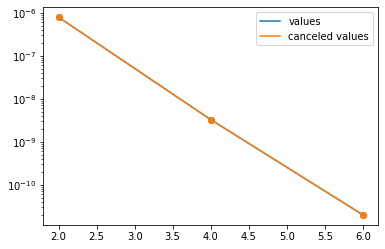

In [19]:
vals = []
vals_canceled = []
deglist = [2,4,6,8]#,16]
for degree in deglist:
    traffointegral = integrate(A, B, tensorgauss(degree), TcommonVertex)
    traffointegral_cancled = integrate(A, B, tensorgauss(degree), TcommonVertex_canceled)
    vals.append(traffointegral[0,0])
    vals_canceled.append(traffointegral_cancled[0,0])
vals = np.array(vals)
vals -= vals[-1]

vals_canceled = np.array(vals_canceled)
vals_canceled -= vals_canceled[-1]

print("degrees", deglist,"\n values", vals)
print("degrees", deglist,"\n cancled values", vals_canceled)

plt.plot(deglist[:-1], np.abs(vals[:-1]), label ="values" )
plt.scatter(deglist[:-1], np.abs(vals[:-1]))

plt.plot(deglist[:-1], np.abs(vals_canceled[:-1]), label ="canceled values" )
plt.scatter(deglist[:-1], np.abs(vals_canceled[:-1]))

plt.legend()
plt.yscale("log")
plt.show()

# Transform Functions: $A \cap B = \{ v_0, v_1 \}$

In [20]:
def T1commonEdge(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2
    return xi*np.array([1.,
                        eta1*eta3,
                        1. - eta1*eta2,
                        eta1*(1. - eta2)
                       ]), det

def T2commonEdge(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1.,
                        eta1,
                        1. - eta1*eta2*eta3,
                        eta1*eta2*(1-eta3)
                       ]), det

def T3commonEdge(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1.-eta1*eta2,
                        eta1*(1.-eta2),
                        1.,
                        eta1*eta2*eta3
                       ]), det

def T4commonEdge(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1.-eta1*eta2*eta3,
                        eta1*eta2*(1.-eta3),
                        1.,
                        eta1
                       ]), det

def T5commonEdge(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1.-eta1*eta2*eta3,
                        eta1*(1. - eta2*eta3),
                        1.,
                        eta1*eta2
                       ]), det

TcommonEdge = [T1commonEdge, T2commonEdge, T3commonEdge, T4commonEdge, T5commonEdge]

def T1commonEdge_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2
    return np.array([1.,
                        eta1*eta3,
                        1. - eta1*eta2,
                        eta1*(1. - eta2)
                       ]), det

def T2commonEdge_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1.,
                        eta1,
                        1. - eta1*eta2*eta3,
                        eta1*eta2*(1-eta3)
                       ]), det

def T3commonEdge_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1.-eta1*eta2,
                        eta1*(1.-eta2),
                        1.,
                        eta1*eta2*eta3
                       ]), det

def T4commonEdge_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1.-eta1*eta2*eta3,
                        eta1*eta2*(1.-eta3),
                        1.,
                        eta1
                       ]), det

def T5commonEdge_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1.-eta1*eta2*eta3,
                        eta1*(1. - eta2*eta3),
                        1.,
                        eta1*eta2
                       ]), det

TcommonEdge_canceled = [T1commonEdge_canceled, T2commonEdge_canceled, 
                        T3commonEdge_canceled, T4commonEdge_canceled, 
                        T5commonEdge_canceled]

### Plot of Quadrature Rule

To get a feeling only we plot the quadrature points and connect points which enter the quadrature rule together by a line.

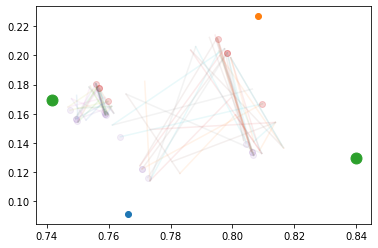

In [80]:
A, B, nEqual = Triangles.join(0,2)
#print(A.E, "\n", B.E)
q = tensorgauss(2)

x_list = np.zeros((q.deg**q.dim, 2))
y_list = np.zeros((q.deg**q.dim, 2))

plt.scatter(A.E[:,0], A.E[:,1])
plt.scatter(B.E[:,0], B.E[:,1])
plt.scatter(B.E[:nEqual,0], B.E[:nEqual,1], s = 120)

for T in TcommonEdge:
    for k, alpha in enumerate(q.points.T):
        alpha = scale(alpha)
        alpha, Tdet = T(alpha)
        alpha = mirror(alpha)
        x = A(alpha[:2])
        y = B(alpha[2:])
        plt.plot([x[0],y[0]], [x[1],y[1]], alpha=.09)
        x_list[k] = x
        y_list[k] = y
    
plt.scatter(y_list[:,0], y_list[:, 1], alpha=.1)
plt.scatter(x_list[:,0], x_list[:, 1], alpha=.1)
    
plt.show() 

## Comparison to Common Vertex Integral

As quadrature points do not really meet it is possible to compare the result with the transformation of the common vertex case, just as another sanity check.

In [22]:
traffointegral = integrate(A, B, tensorgauss(8), TcommonVertex)
traffointegral

array([[1.02481193e-04, 3.31455562e-05],
       [3.31455562e-05, 1.93030728e-04]])

In [23]:
traffointegral = integrate(A, B, tensorgauss(8), TcommonEdge)
traffointegral

array([[1.02309796e-04, 3.30833744e-05],
       [3.30833744e-05, 1.93206900e-04]])

In [24]:
traffointegral = integrate(A, B, tensorgauss(8), TcommonEdge_canceled)
traffointegral

array([[1.02309796e-04, 3.30833744e-05],
       [3.30833744e-05, 1.93206900e-04]])

# Transform Functions: $A = B $

In [25]:
def T1identical(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1., 
                         1. - eta1 + eta1*eta2,
                         1. - eta1*eta2*eta3,
                         1. - eta1
                        ]), det
def T2identical(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1. - eta1*eta2*eta3, 
                         1. - eta1,
                         1.,
                         1. - eta1 + eta1*eta2
                        ]), det
def T3identical(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1., 
                         eta1*(1. - eta2 + eta2*eta3),
                         1. - eta1*eta2,
                         eta1*(1. - eta2)
                        ]), det
def T4identical(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1.-eta1*eta2, 
                         eta1*(1. - eta2),
                         1.,
                         eta1*(1. - eta2 + eta2*eta3)
                        ]), det
def T5identical(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1.-eta1*eta2*eta3, 
                         eta1*(1. - eta2*eta3),
                         1.,
                         eta1*(1. - eta2)
                        ]), det
def T6identical(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**3*eta1**2*eta2
    return xi*np.array([1., 
                         eta1*(1. - eta2),
                         1. - eta1*eta2*eta3,
                         eta1*(1. - eta2*eta3)
                        ]), det

Tidentical = [T1identical, T2identical, T3identical, T4identical, 
              T5identical, T6identical]

def T1identical_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1., 
                         1. - eta1 + eta1*eta2,
                         1. - eta1*eta2*eta3,
                         1. - eta1
                        ]), det
def T2identical_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1. - eta1*eta2*eta3, 
                         1. - eta1,
                         1.,
                         1. - eta1 + eta1*eta2
                        ]), det
def T3identical_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1., 
                         eta1*(1. - eta2 + eta2*eta3),
                         1. - eta1*eta2,
                         eta1*(1. - eta2)
                        ]), det
def T4identical_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1.-eta1*eta2, 
                         eta1*(1. - eta2),
                         1.,
                         eta1*(1. - eta2 + eta2*eta3)
                        ]), det
def T5identical_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1.-eta1*eta2*eta3, 
                         eta1*(1. - eta2*eta3),
                         1.,
                         eta1*(1. - eta2)
                        ]), det
def T6identical_canceled(alpha):
    xi, eta1, eta2, eta3 = alpha
    det = xi**2*eta1**2*eta2
    return np.array([1., 
                         eta1*(1. - eta2),
                         1. - eta1*eta2*eta3,
                         eta1*(1. - eta2*eta3)
                        ]), det
Tidentical_canceled = [T1identical_canceled, T2identical_canceled, T3identical_canceled, 
               T4identical_canceled, T5identical_canceled, T6identical_canceled]


### Plot of Quadrature Rule

[[0.74154928 0.16913386]
 [0.76629709 0.09146897]
 [0.84000793 0.12954425]] 
 [[0.74154928 0.16913386]
 [0.76629709 0.09146897]
 [0.84000793 0.12954425]]


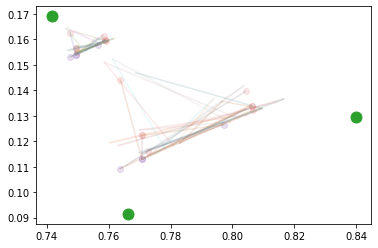

In [76]:
A, B, nEqual = Triangles.join(0,0)
print(A.E, "\n", B.E)
q = tensorgauss(2)

x_list = np.zeros((q.deg**q.dim, 2))
y_list = np.zeros((q.deg**q.dim, 2))

plt.scatter(A.E[:,0], A.E[:,1])
plt.scatter(B.E[:,0], B.E[:,1])
plt.scatter(B.E[:nEqual,0], B.E[:nEqual,1], s = 120)

for T in Tidentical:
    for k, alpha in enumerate(q.points.T):
        alpha = scale(alpha)
        alpha, Tdet = T(alpha)
        alpha = mirror(alpha)
        x = A(alpha[:2])
        y = B(alpha[2:])
        plt.plot([x[0],y[0]], [x[1],y[1]], alpha=.09)
        x_list[k] = x
        y_list[k] = y

plt.scatter(y_list[:,0], y_list[:, 1], alpha=.1)
plt.scatter(x_list[:,0], x_list[:, 1], alpha=.1)
    
plt.show() 

### Comparison to Common Edge Integral

In [73]:
traffointegral = integrate(A, B, tensorgauss(2), TcommonVertex)
traffointegral

array([[ 0.00025511, -0.00011175],
       [-0.00011175,  0.00023439]])

In [74]:
traffointegral = integrate(A, B, tensorgauss(2), Tidentical)
traffointegral

array([[ 2.42834698e-04, -3.19121636e-05],
       [-3.19121636e-05,  2.69239715e-04]])

In [75]:
traffointegral = integrate(A, B, tensorgauss(2), Tidentical_canceled)
traffointegral

array([[ 2.42834698e-04, -3.19121636e-05],
       [-3.19121636e-05,  2.69239715e-04]])

# Further Checks

In [65]:
def testKernel(z):
    return z[0]*z[1] - z[1]*3

def integrateTest(A, B, q, T):
    s = 0
    for Tk in T:
        for k, alpha in enumerate(q.points.T):
            alpha = scale(alpha)
            alpha, Tdet = Tk(alpha)
            alpha = mirror(alpha)
            x = A(alpha[:2])
            y = B(alpha[2:])
            
            s+=testKernel(x-y)*scaledet*q.weights[k]*Tdet*A.det*B.det
    return s

def integrateTest_classic(A, B, Px, dx, Py, dy):
    s = 0
    n = dx.shape[0]
    m = dy.shape[0]
    for i in range(n):
        x = A.M@Px[i] + A.a
        for j in range(m):
            y = B.M@Py[j] + B.a
            s += testKernel(x-y)*A.det*dy[j]*B.det*dx[i]
    return s

In [66]:
A, B, nEqual = Triangles.join(0, 224)
q = tensorgauss(4)

transformed = integrateTest(A, B, q, TcommonVertex)
print("\n\nCase Common Vertex:\t", transformed)

classic = integrateTest_classic(A, B, Px, dx, Px, dx)
print("Classical integral:\t", classic)

A, B, nEqual = Triangles.join(0, 2)
q = tensorgauss(4)

transformed = integrateTest(A, B, q, TcommonEdge)
print("\n\nCase Common Edge:\t", transformed)

classic = integrateTest_classic(A, B, Px, dx, Px, dx)
print("Classical integral:\t", classic)

A, B, nEqual = Triangles.join(0, 0)
q = tensorgauss(4)

transformed = integrateTest(A, B, q, Tidentical)
print("\n\nCase Identical Panel:\t", transformed)

classic = integrateTest_classic(A, B, Px, dx, Py, dy)
print("Classical integral:\t", classic)



Case Common Vertex:	 1.5628693748823614e-06
Classical integral:	 1.5628693727153936e-06


Case Common Edge:	 1.8838288319389883e-06
Classical integral:	 1.8838288292303743e-06


Case Identical Panel:	 -1.8603323280324212e-09
Classical integral:	 -1.8603323074420197e-09
